In [27]:
import sys
import os
sys.path.append("../../core/datasets")

from pfdelta_dataset import PFDeltaDataset

import torch
from torch_geometric.datasets import OPFDataset
import pandas 
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import random 
import matplotlib.patches as mpatches
from data_utils import loadcase 
from idx import *

In [28]:
case_info = {
    "case14": {
        "num_samples": 10000,
        "num_buses": 14,
        "num_loads": 11,
        "num_gens": 5,
        "x_ticks": 8,
        "case_path": "../pglib/pglib_opf_case14_ieee.m",
        "opfdata_args":"pglib_opf_case14_ieee"
    },
    "case118": {
        "num_samples": 10000,
        "num_buses": 118,
        "num_loads": 99,
        "num_gens": 54,
        "x_ticks": 8,
        "case_path": "../pglib/pglib_opf_case118_ieee.m",
        "opfdata_args":"pglib_opf_case118_ieee"
    }
}

In [29]:
# Choose a case
selected_case = "case118"

# Access its info
info = case_info[selected_case]

# Now you can use it as individual variables
num_samples = info["num_samples"]
num_buses   = info["num_buses"]
num_loads   = info["num_loads"]
num_gens    = info["num_gens"]
x_ticks     = info["x_ticks"]
case_path   = info["case_path"]

In [30]:
mpc = loadcase(case_path)
spv_mask = (mpc["bus"][:, BUS_TYPE] == 2) | (mpc["bus"][:, BUS_TYPE] == 3)
vmin_array = mpc["bus"][:, VMIN]   # shape (num_buses,)
vmax_array = mpc["bus"][:, VMAX]

In [31]:
# Load new_PFDelta
root = '../my_results/2025-04-24_21-18-06' # double-check path
pfdelta_dataset = PFDeltaDataset(
    root_dir=root,
    split='all', 
    case_name=selected_case, # verify path here,
    # topological_perturbations=True, # this has to be added to the class: have it load the correct perturbation?
    force_reload=False
)

# remains to be seen if it will work exactly like this.
pg_full = torch.zeros((num_samples, num_buses))
qg_full = torch.zeros((num_samples, num_buses))
pd = torch.zeros((num_samples, num_loads))
qd = torch.zeros((num_samples, num_loads))
vm = torch.zeros((num_samples, num_buses))
va = torch.zeros((num_samples, num_buses))

for i in range(num_samples):
    pg = pfdelta_dataset[i]['gen']['generation'][:, 0]
    qg = pfdelta_dataset[i]['gen']['generation'][:, 1]
    gen_bus = pfdelta_dataset[i]["gen", "gen_link", "bus"]['edge_index'][1, :]
    pg_full[i, :].scatter_add_(0, gen_bus, pg)
    qg_full[i, :].scatter_add_(0, gen_bus, qg)

    pd[i, :] =  pfdelta_dataset[i]['load']['demand'][:, 0]
    qd[i, :] = pfdelta_dataset[i]['load']['demand'][:, 1]
    vm[i, :] = pfdelta_dataset[i]['bus']['bus_voltages'][:, 1]
    va[i, :] = pfdelta_dataset[i]['bus']['bus_voltages'][:, 0]

pg = pg_full[:, spv_mask]
qg = qg_full[:, spv_mask]

new_pfdelta = {'pd': pd, 'qd': qd, 'pg': pg, 'qg': qg, 'vm': vm, 'va': va}

Processing...


Processing split: train (8000 files)


Building train data: 100%|██████████| 8000/8000 [01:00<00:00, 131.16it/s]


Processing split: val (1000 files)


Building val data: 100%|██████████| 1000/1000 [00:07<00:00, 135.20it/s]


Processing split: test (1000 files)


Building test data: 100%|██████████| 1000/1000 [00:07<00:00, 133.05it/s]


Processing split: all (10000 files)


Building all data: 100%|██████████| 10000/10000 [01:15<00:00, 132.64it/s]
Done!
/Users/anarivera/opt/miniconda3/envs/delta_pf/lib/python3.10/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([BaseStorage])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


In [32]:
# Load OPFData
root = '../opfdata'
opfdata_dataset = OPFDataset(
    root=root,
    num_groups=1, 
    split='train', 
    case_name=info["opfdata_args"], 
    topological_perturbations=True,
    force_reload=False
)

pg_full = torch.zeros((num_samples, num_buses))
qg_full = torch.zeros((num_samples, num_buses))
pd = torch.zeros((num_samples, num_loads))
qd = torch.zeros((num_samples, num_loads))
vm = torch.zeros((num_samples, num_buses))
va = torch.zeros((num_samples, num_buses))

for i in range(num_samples):
    pg = opfdata_dataset[i]['generator']['y'][:, 0]
    qg = opfdata_dataset[i]['generator']['y'][:, 1]
    gen_bus = opfdata_dataset[i]["generator", "generator_link", "bus"]['edge_index'][1, :]
    pg_full[i, :].scatter_add_(0, gen_bus, pg)
    qg_full[i, :].scatter_add_(0, gen_bus, qg)
    pd[i, :] =  opfdata_dataset[i]['load']['x'][:, 0]
    qd[i, :] = opfdata_dataset[i]['load']['x'][:, 1]
    vm[i, :] = opfdata_dataset[i]['bus']['y'][:, 1]
    va[i, :] = opfdata_dataset[i]['bus']['y'][:, 0]

pg = pg_full[:, spv_mask]
qg = qg_full[:, spv_mask]

opfdata = {'pd': pd, 'qd': qd, 'pg': pg, 'qg': qg, 'vm': vm, 'va': va}

In [33]:
# Checking unit of voltage angles in this data:
opfdata_dataset[0]["bus"].y

tensor([[-4.2443e-01,  1.0233e+00],
        [-4.2125e-01,  1.0299e+00],
        [-4.1030e-01,  1.0308e+00],
        [-3.4670e-01,  1.0600e+00],
        [-3.3749e-01,  1.0585e+00],
        [-3.9052e-01,  1.0522e+00],
        [-3.9985e-01,  1.0477e+00],
        [-2.4365e-01,  1.0480e+00],
        [-1.0699e-01,  1.0600e+00],
        [ 3.9723e-02,  1.0535e+00],
        [-3.9401e-01,  1.0407e+00],
        [-4.0916e-01,  1.0418e+00],
        [-4.1224e-01,  1.0303e+00],
        [-4.1775e-01,  1.0421e+00],
        [-4.1402e-01,  1.0466e+00],
        [-4.0559e-01,  1.0414e+00],
        [-3.6149e-01,  1.0600e+00],
        [-4.0554e-01,  1.0514e+00],
        [-4.1631e-01,  1.0463e+00],
        [-3.8556e-01,  1.0307e+00],
        [-3.4869e-01,  1.0241e+00],
        [-2.9557e-01,  1.0275e+00],
        [-1.9660e-01,  1.0445e+00],
        [-1.9467e-01,  1.0432e+00],
        [-6.1481e-02,  1.0600e+00],
        [-7.4640e-03,  1.0297e+00],
        [-3.0998e-01,  1.0397e+00],
        [-3.4011e-01,  1.029

In [34]:
# Load OPFLearn CSV
opflearn_path = os.path.join("..", "opflearn", selected_case, info["opfdata_args"] + ".csv")
df = pandas.read_csv(opflearn_path)

# Load pd, qd as torch tensors
pd = torch.tensor(df.filter(regex=r'^load\d+:pl$', axis=1).to_numpy(), dtype=torch.float32)
qd = torch.tensor(df.filter(regex=r'^load\d+:ql$', axis=1).to_numpy(), dtype=torch.float32)

# Load pg, qg as torch tensors
pg = torch.tensor(df.filter(regex=r'^gen\d+:pg$', axis=1).to_numpy(), dtype=torch.float32)
qg = torch.tensor(df.filter(regex=r'^gen\d+:qg$', axis=1).to_numpy(), dtype=torch.float32)
# Extract complex bus voltages from dataframe
vm_df = df.filter(regex=r'^bus\d+:v_bus$', axis=1)

def safe_complex(val):
    if isinstance(val, str):
        val = val.replace(" + ", "+").replace(" - ", "-")
        try:
            return complex(val)
        except ValueError:
            return np.nan
    return val if isinstance(val, complex) else np.nan

# Parse v_bus strings into complex numbers
vm_complex = vm_df.applymap(safe_complex).to_numpy()

# 🔧 FIX: Correct angle encoding by scaling angle by -180/pi
v_bus_corrected = np.abs(vm_complex) * np.exp(1j * -np.degrees(np.angle(vm_complex)))

# Convert corrected values to torch tensors
vm = torch.tensor(np.abs(v_bus_corrected), dtype=torch.float32)
va = torch.tensor(np.angle(v_bus_corrected), dtype=torch.float32)

# Infer shape
num_samples, num_buses = vm.shape
num_gens = pg.shape[1]

# Expand gen_bus for broadcasting
gen_bus = mpc['gen'][:, GEN_BUS].to(torch.long)
gen_bus_expanded = gen_bus.unsqueeze(0).expand(num_samples, -1) # shape [num_samples, num_gens]

# Scatter into full [num_samples, num_buses] tensors
pg_full = torch.zeros((num_samples, num_buses), dtype=pg.dtype)
qg_full = torch.zeros((num_samples, num_buses), dtype=qg.dtype)
pg_full.scatter_add_(1, gen_bus_expanded, pg)
qg_full.scatter_add_(1, gen_bus_expanded, qg)

# Select only spv_mask columns
pg = pg_full[:, spv_mask]
qg = qg_full[:, spv_mask]

# Final OPFLearn dictionary
opflearn = {
    'pd': pd,
    'qd': qd,
    'pg': pg,
    'qg': qg,
    'vm': vm,
    'va': va
}

/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_3312/18724742.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vm_complex = vm_df.applymap(safe_complex).to_numpy()


In [35]:
# Load old_PFDelta
path_to_data = os.path.join("..", "old_pfdelta", "30000opfv2dataset_"+ selected_case + "_ieee.mat")

our_data = scipy.io.loadmat(path_to_data)
baseMVA = our_data["baseMVA"]
print(baseMVA.dtype)
pd_ = our_data["bus"][:, 2]
qd_ = our_data["bus"][:, 3]
load_bus_mask = (pd_ > 0) | (qd_ > 0)
gen_bus = torch.tensor(our_data["gen"][:, 0], dtype=torch.long) - 1 
gen_bus_expanded = gen_bus.expand(num_samples, -1)
spv_bus_mask = torch.tensor(our_data["bus"][:, 1] != 1, dtype=torch.bool)

# Get variables
pd = torch.tensor(np.real(our_data['Dem'][load_bus_mask, :].T) / 100)
qd = torch.tensor(np.imag(our_data['Dem'][load_bus_mask, :].T) / 100)
pg = torch.tensor(np.real(our_data['Gen'].T) / 100)
qg = torch.tensor(np.imag(our_data['Gen'].T) / 100)
vm = torch.tensor(np.abs(our_data['Vol'].T))
va = torch.tensor(np.angle(our_data['Vol'].T))

pg_full = torch.zeros((num_samples, num_buses), dtype=pg.dtype)
qg_full = torch.zeros((num_samples, num_buses), dtype=qg.dtype)
pg_full.scatter_add_(1, gen_bus_expanded, pg)
qg_full.scatter_add_(1, gen_bus_expanded, qg)
pg = pg_full[:, spv_bus_mask]
qg = qg_full[:, spv_bus_mask]

old_pfdelta = {'pd': pd, 'qd': qd, 'pg': pg, 'qg': qg, 'vm': vm, 'va': va}

uint8


In [36]:
# box plot settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams["axes.labelsize"] = 14  # Font size for x and y labels
plt.rcParams["axes.titlesize"] = 16  # Font size for title
plt.rcParams["xtick.labelsize"] = 12  # Font size for x-tick labels
plt.rcParams["ytick.labelsize"] = 12  # Font size for y-tick labels
plt.rcParams["legend.fontsize"] = 12 

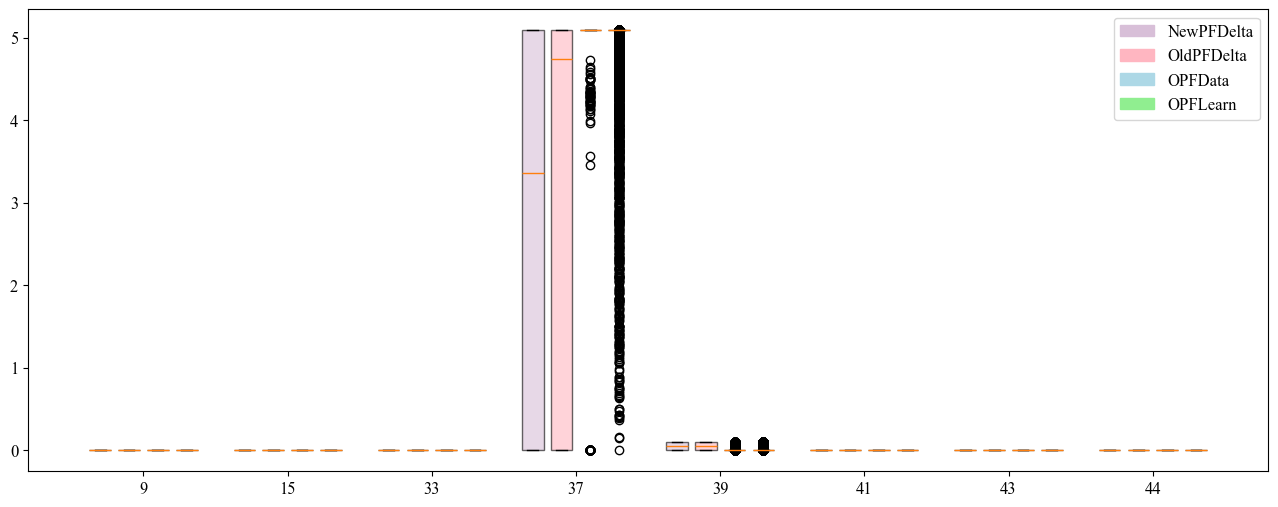

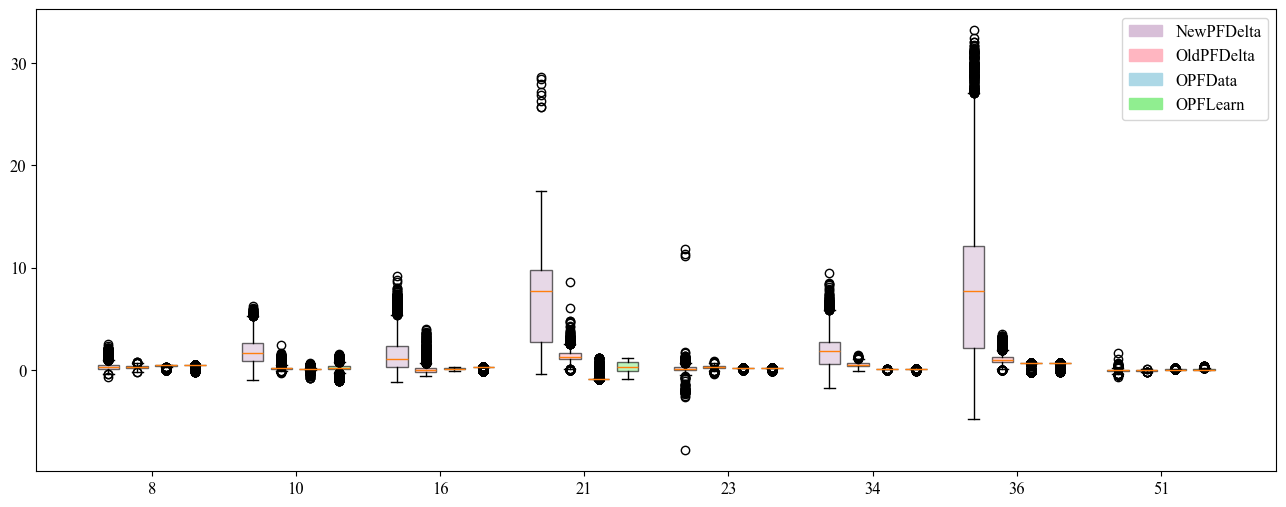

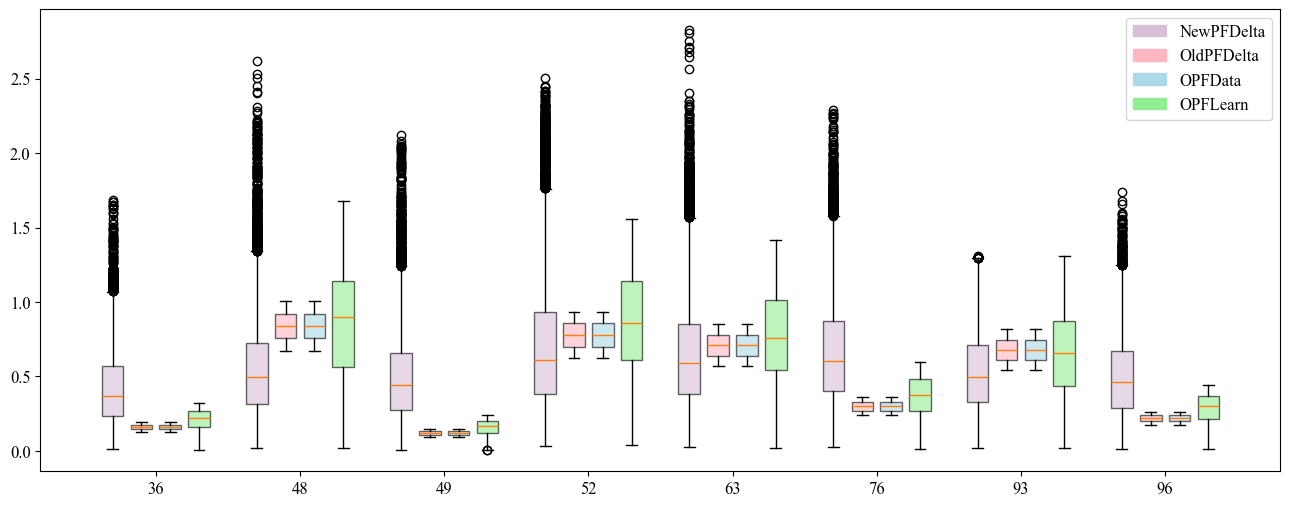

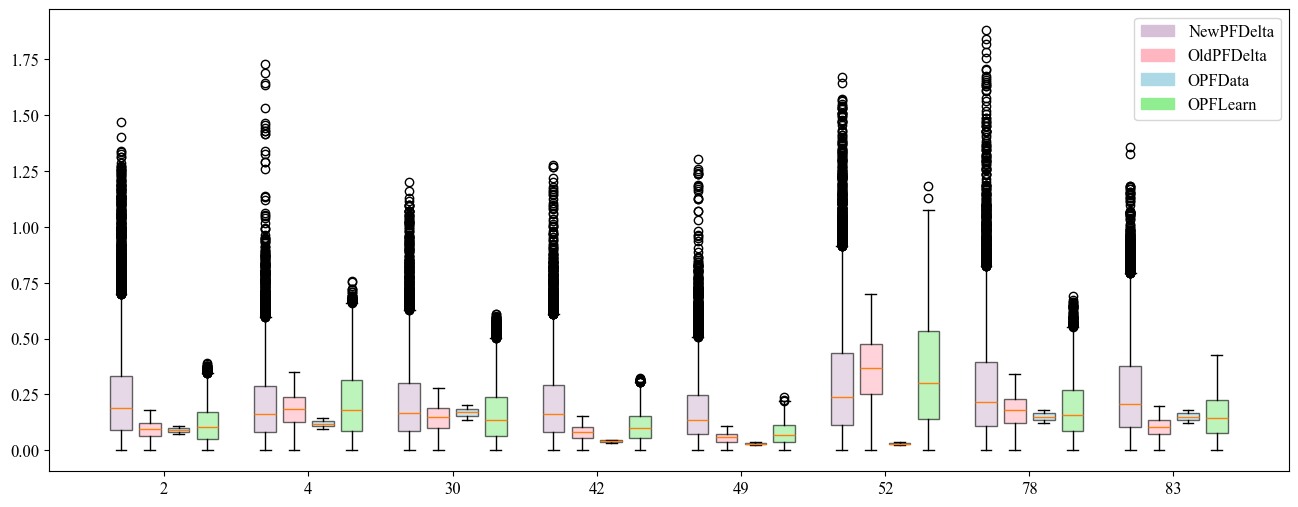

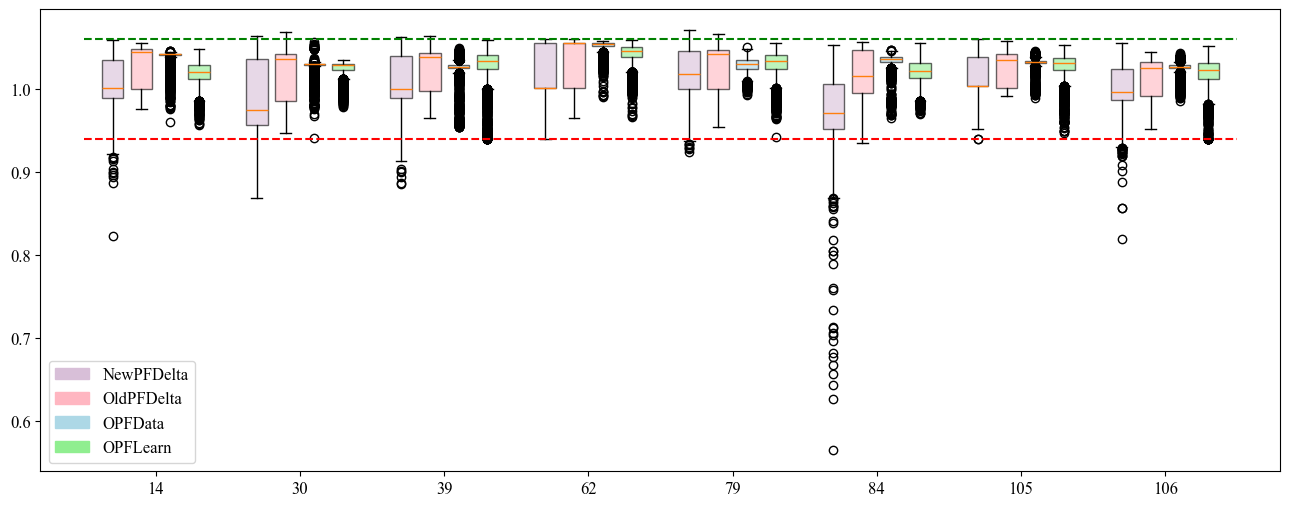

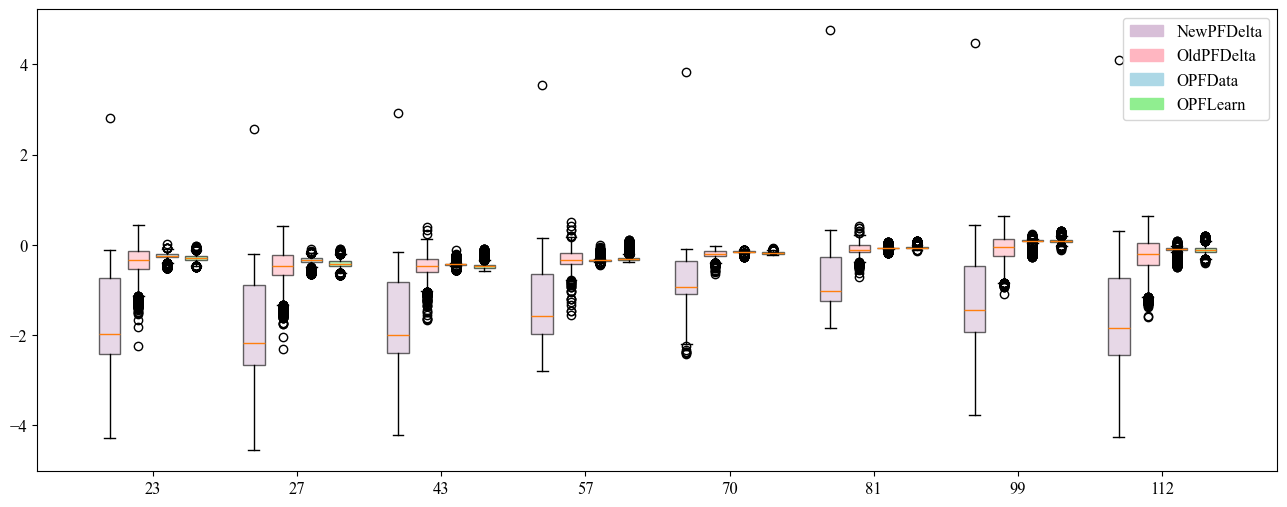

In [37]:
vars_to_plot = {
                "pg": sorted(random.sample(range(num_gens), x_ticks)) if x_ticks < num_gens else sorted(random.sample(range(num_gens), num_gens)),
                "qg": sorted(random.sample(range(num_gens), x_ticks)) if x_ticks < num_gens else sorted(random.sample(range(num_gens), num_gens)),
                "pd": sorted(random.sample(range(num_loads), x_ticks)) if x_ticks < num_loads else sorted(random.sample(range(num_gens), num_loads)),
                "qd": sorted(random.sample(range(num_loads), x_ticks)) if x_ticks < num_loads else sorted(random.sample(range(num_gens), num_loads)),
                "vm": sorted(random.sample(range(num_buses), x_ticks)),
                "va": sorted(random.sample(range(num_buses), x_ticks))
                }
colors = ["#D8BFD8", "#FFB6C1", "#ADD8E6", "#90EE90"]
group_labels = ["NewPFDelta", "OldPFDelta", "OPFData", "OPFLearn"]
for var, indices in vars_to_plot.items():
    data = []
    for i in indices:
        data.append(new_pfdelta[var][:, i].numpy())
        data.append(old_pfdelta[var][:, i].numpy())
        data.append(opfdata[var][:, i].numpy())
        data.append(opflearn[var][:, i].numpy())

    positions = np.array([np.arange(len(indices)) + i * 0.2 for i in range(4)]).T.flatten()

    fig, ax = plt.subplots(figsize=(16, 6))
    boxplot = ax.boxplot(data, positions=positions, widths=0.15, showfliers=True, patch_artist=True)

    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % 4])
        patch.set_alpha(0.6)

    xtick_positions = np.arange(len(indices)) + 0.3
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels([f"{i+1}" for i in indices])

    legend_patches = [mpatches.Patch(color=colors[i], label=group_labels[i]) for i in range(4)]
    ax.legend(handles=legend_patches, loc="best")

    # -----------------------
    # Only for voltages (vm):
    # -----------------------

    if var == "vm":
        for idx, bus_idx in enumerate(indices):
            vmin = vmin_array[bus_idx]
            vmax = vmax_array[bus_idx]
            ax.hlines(vmin, idx-0.2, idx+0.8, colors='red', linestyles='--', label='Vmin' if idx == 0 else "")
            ax.hlines(vmax, idx-0.2, idx+0.8, colors='green', linestyles='--', label='Vmax' if idx == 0 else "")

    plt.show()


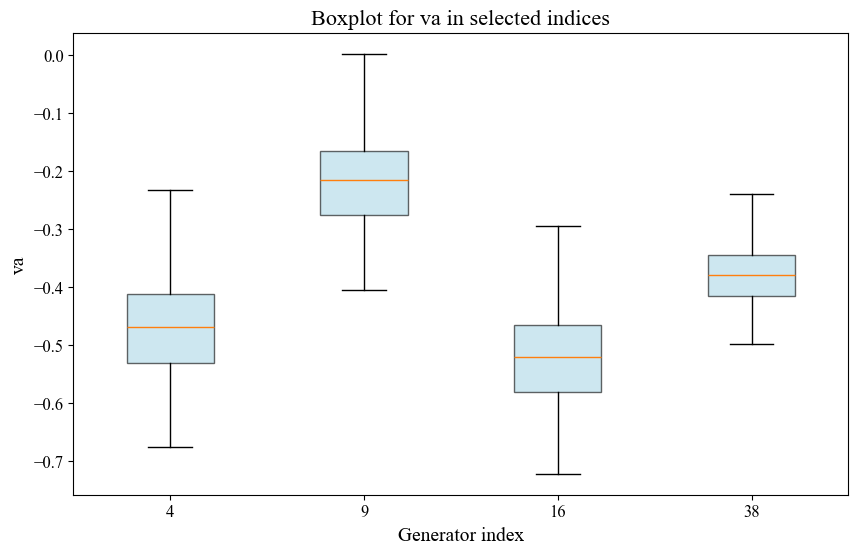

In [38]:
# Look at weird stuff

# Example setup
var = "va"
dataset = opflearn  # Choose between new_pfdelta, opfdata, or opflearn
num_buses = dataset["va"].shape[1]  # adjust depending on your case
indices = sorted(random.sample(range(num_gens), 4))  # pick 4 random generators

# Collect the data
data = [dataset[var][:, i].numpy() for i in indices]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = ax.boxplot(data, patch_artist=True, showfliers=False)

# Styling (optional)
for patch in boxplot['boxes']:
    patch.set_facecolor("#ADD8E6")  # light blue
    patch.set_alpha(0.6)

# Set x-ticks
ax.set_xticks(np.arange(1, len(indices) + 1))
ax.set_xticklabels([f"{i+1}" for i in indices])

ax.set_title(f"Boxplot for {var} in selected indices")
ax.set_ylabel(var)
ax.set_xlabel("Generator index")

plt.show()

In [39]:
# Include here plots on tries to feasible sample

In [40]:
# Plots for densities of contingencies

In [41]:
# Plots for densities of costs